##FACIAL SKIN ANALYSIS

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [5]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [6]:
train_df = create_df("kaggle/Oily-Dry-Skin-Types/train")
val_df = create_df("kaggle/Oily-Dry-Skin-Types/valid")
test_df = create_df("kaggle/Oily-Dry-Skin-Types/test")

In [7]:
train_df = pd.concat([train_df, val_df, test_df])

In [8]:
train_df

,images,labels
0,kaggle/Oily-Dry-Skin-Types/train\dry\dry_003e3...,0
1,kaggle/Oily-Dry-Skin-Types/train\dry\dry_003e3...,0
2,kaggle/Oily-Dry-Skin-Types/train\dry\dry_003e3...,0
3,kaggle/Oily-Dry-Skin-Types/train\dry\dry_00f11...,0
4,kaggle/Oily-Dry-Skin-Types/train\dry\dry_00f11...,0
...,...,...
129,kaggle/Oily-Dry-Skin-Types/test\oily\oily_e31f...,2
130,kaggle/Oily-Dry-Skin-Types/test\oily\oily_e50d...,2
131,kaggle/Oily-Dry-Skin-Types/test\oily\oily_f1ff...,2
132,kaggle/Oily-Dry-Skin-Types/test\oily\oily_f5dc...,2


In [9]:
train_df.tail(250)

,images,labels
146,kaggle/Oily-Dry-Skin-Types/valid\normal\normal...,1
147,kaggle/Oily-Dry-Skin-Types/valid\normal\normal...,1
148,kaggle/Oily-Dry-Skin-Types/valid\normal\normal...,1
149,kaggle/Oily-Dry-Skin-Types/valid\normal\normal...,1
150,kaggle/Oily-Dry-Skin-Types/valid\normal\normal...,1
...,...,...
129,kaggle/Oily-Dry-Skin-Types/test\oily\oily_e31f...,2
130,kaggle/Oily-Dry-Skin-Types/test\oily\oily_e50d...,2
131,kaggle/Oily-Dry-Skin-Types/test\oily\oily_f1ff...,2
132,kaggle/Oily-Dry-Skin-Types/test\oily\oily_f5dc...,2


In [10]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [11]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

In [12]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [13]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [14]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [15]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [16]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [18]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [19]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []


In [20]:

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],train_acc[-1], val_loss[-1],val_acc[-1]))

Epochs 1 train loss 0.04622414879551108 acc 0.4395081316937723 val loss 0.03405280075375996 acc 0.4507936507936508
Epochs 2 train loss 0.02528073024248519 acc 0.650535501785006 val loss 0.0338449377862234 acc 0.546031746031746
Epochs 3 train loss 0.016451995744444177 acc 0.7945259817532725 val loss 0.042266514755430674 acc 0.5682539682539682
Epochs 4 train loss 0.011128158187024511 acc 0.8655295517651725 val loss 0.03168437499848623 acc 0.6158730158730159
Epochs 5 train loss 0.007450603776179529 acc 0.9159063863546212 val loss 0.02635622876031058 acc 0.6952380952380952
Epochs 6 train loss 0.005416845476483126 acc 0.9480364934549782 val loss 0.028913140296936035 acc 0.6888888888888889
Epochs 7 train loss 0.004448014982739217 acc 0.9527965093216978 val loss 0.023641155163447062 acc 0.7682539682539683
Epochs 8 train loss 0.003139056352538658 acc 0.9694565648552161 val loss 0.031425150330104526 acc 0.7587301587301587
Epochs 9 train loss 0.002485247815041871 acc 0.9773899246330822 val loss 

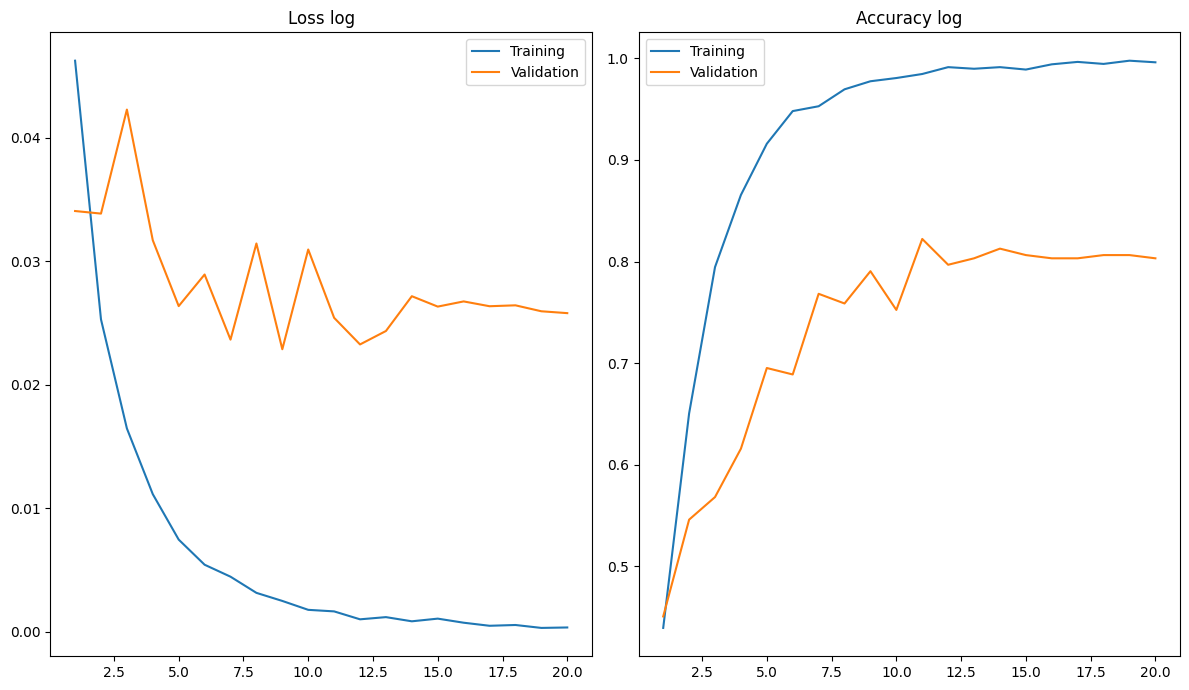

In [21]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()


In [22]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

In [23]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

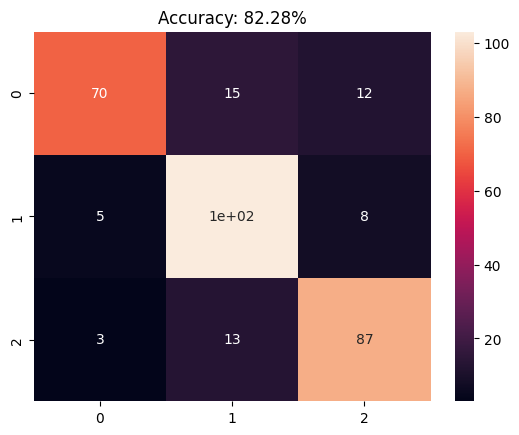

In [24]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [25]:
print(report)

              precision    recall  f1-score   support

           0       0.90      0.72      0.80        97
           1       0.79      0.89      0.83       116
           2       0.81      0.84      0.83       103

    accuracy                           0.82       316
   macro avg       0.83      0.82      0.82       316
weighted avg       0.83      0.82      0.82       316



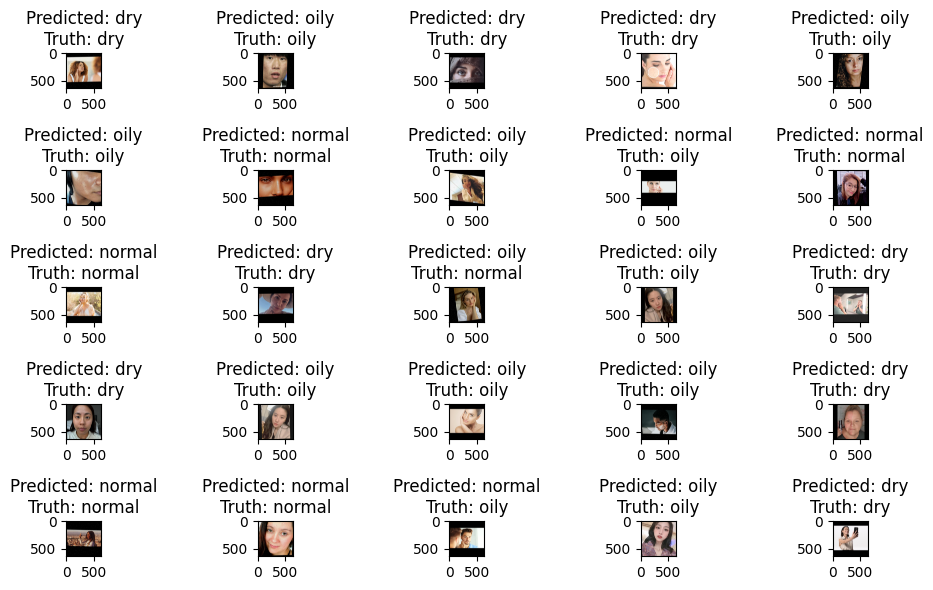

In [42]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

In [60]:
image_path = "OIP.jpeg"
predicted_label = predict(image_path)
ans = index_label[predicted_label]
print(ans)

oily


In [37]:
image_path = "myphoto5.jpg"
predicted_label = predict(image_path)
ans = index_label[predicted_label]
print(ans)

dry


In [43]:
image_path = "hari1.jpg"
predicted_label = predict(image_path)
ans = index_label[predicted_label]
print(ans)

normal


In [59]:
image_path = "oily.jpeg"
predicted_label = predict(image_path)
ans = index_label[predicted_label]
print(ans)

oily


In [61]:
import joblib

# Assuming model is your trained machine learning model
joblib.dump(best_model, 'model.pkl')

['model.pkl']